# DWthon 9.0 - Day-ahead electricity price forecasting

### 📚 Import the required libraries:

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as ctb

from pylab import rcParams
import statsmodels
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
import holidays
import eli5

import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator

### 💾  Load the dataset:

In [2]:
df = pd.read_csv("../input/energy_price.csv", parse_dates=["datetime"], index_col="datetime")
df.head()

,price,is_test
datetime,,
2019-06-28 00:00:00,220.54,False
2019-06-28 01:00:00,203.85,False
2019-06-28 02:00:00,203.85,False
2019-06-28 03:00:00,203.85,False
2019-06-28 04:00:00,203.85,False


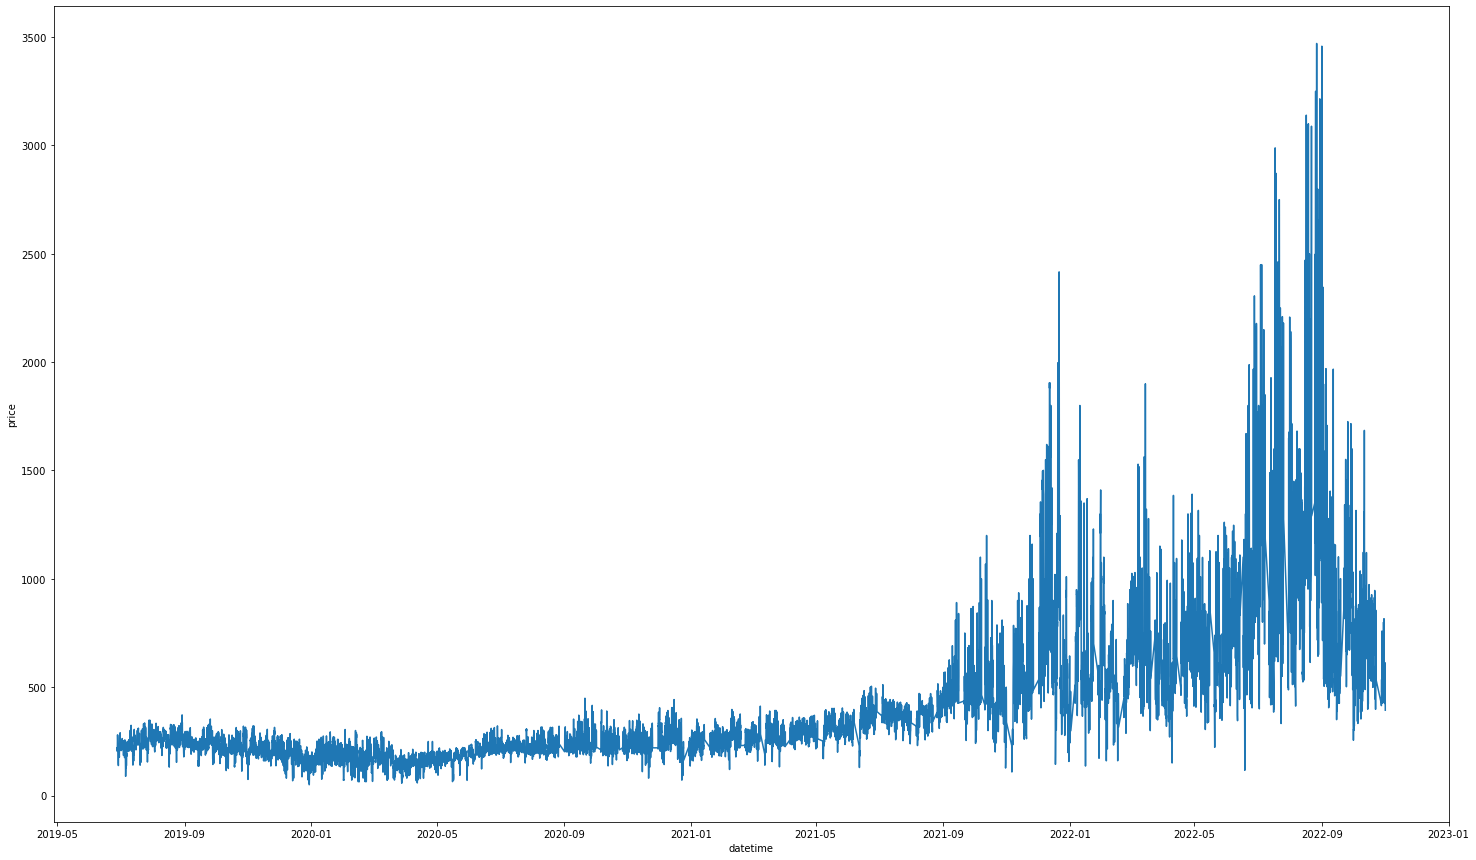

In [4]:
plt.figure(figsize=(25, 15))
sns.lineplot(x='datetime', y='price', data=df);

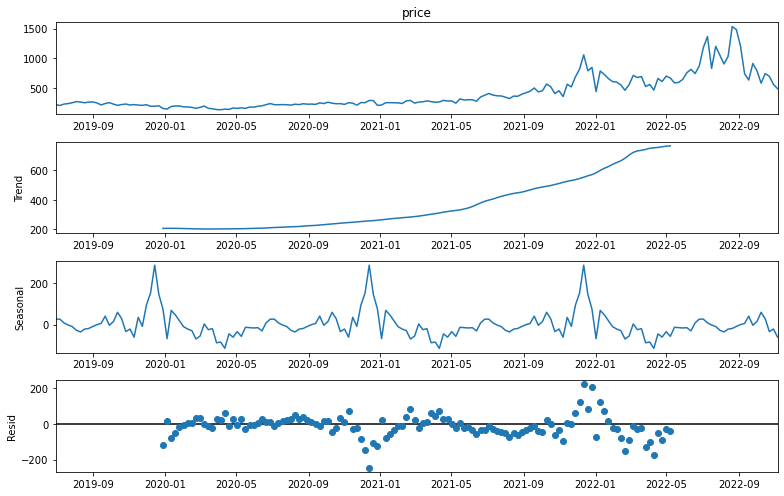

In [5]:
rcParams['figure.figsize'] = 11, 7
df_0_1m = df.resample('1W').mean()
decomposition = sm.tsa.seasonal_decompose(df_0_1m.price, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

### 🔍 Preprocess the data:

In [6]:
df = df.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df["datetime_b24h"] = df["datetime"].shift(24)
is_valid_datetime_set = set(df[ df["is_test"] ]["datetime_b24h"])
df["is_valid"] = df["datetime"].map(lambda x: x in is_valid_datetime_set)

df["datetime_b48h"] = df["datetime"].shift(48)
is_train_datetime_set = set(df[ df["is_test"] ]["datetime_b48h"])
df["is_train"] = df["datetime"].map(lambda x: x in is_train_datetime_set)

In [9]:
df_s = df[(df["is_train"]) | (df["is_valid"])].copy()
df_s.set_index('datetime', inplace=True)

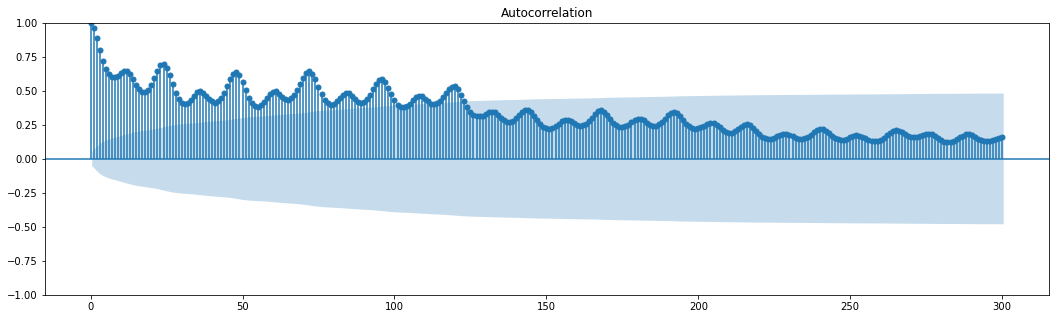

In [10]:
fig = plt.figure(figsize=(15, 5))
sm.graphics.tsa.plot_acf(df_s["price"], lags=300, ax=plt.gca());

/opt/conda/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


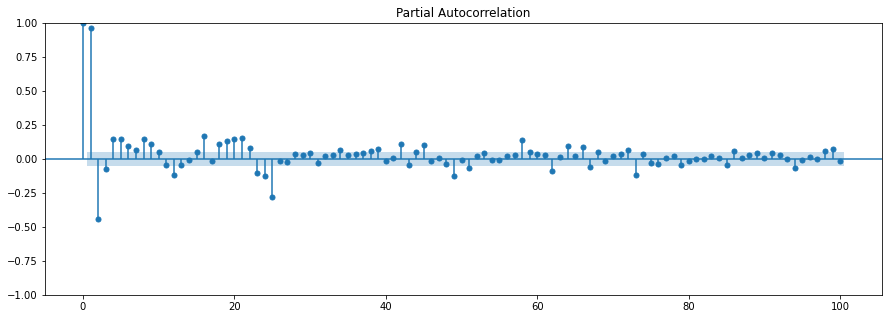

In [12]:
fig = plt.figure(figsize=(15, 5))
sm.graphics.tsa.plot_pacf(df_s["price"], lags=100, ax=plt.gca());

In [13]:
model = auto_arima(df_s['price'], seasonal=True, m=24, trend='c', trace=True)

order = model.order
seasonal_order = model.seasonal_order
print(model.order)
print(model.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=16639.780, Time=25.24 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=17368.329, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=16840.984, Time=4.74 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=16956.235, Time=4.96 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=17368.329, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=16802.626, Time=21.29 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=16758.553, Time=23.51 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=16643.450, Time=80.95 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=16641.566, Time=74.62 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=16947.071, Time=1.33 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=16773.078, Time=68.58 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=16715.968, Time=77.09 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=inf, Time=76.66 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=21.77 sec
 ARIMA(2

In [13]:
sarima_model = SARIMAX(df['price'],  order=(19, 1, 2), seasonal_order=(1, 0, 1, 24))
sarima_model_fit = sarima_model.fit()

filled_data = df['price'].copy()
filled_data[df['price'].isnull()] = sarima_model_fit.predict(start=df['price'].first_valid_index(), end=df['price'].last_valid_index())[df['price'].isnull()]

In [14]:
df['price'] = df['price'].fillna(filled_data)

In [15]:
df = df.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])

In [16]:
df_test = df[ df["is_test"] ].copy()
df_test.sample(5)

,index,datetime,price,is_test,datetime_b24h,is_valid,datetime_b48h,is_train
25474,25474,2022-08-22 13:00:00,1193.660660,True,2022-08-21 13:00:00,False,2022-08-20 13:00:00,False
21515,21515,2022-02-17 13:00:00,457.612110,True,2022-02-16 13:00:00,False,2022-02-15 13:00:00,False
23377,23377,2022-05-16 04:00:00,711.792570,True,2022-05-15 04:00:00,False,2022-05-14 04:00:00,False
14823,14823,2021-04-02 17:00:00,247.659588,True,2021-04-01 17:00:00,False,2021-03-31 17:00:00,False
19267,19267,2021-11-01 21:00:00,397.845012,True,2021-10-31 21:00:00,False,2021-10-30 21:00:00,False


In [17]:
df_test[["datetime", "price"]].to_csv("../output/sarima_19_1_2_1_0_1_24.csv", index=False)

__The best score on Kaggle:__   
__ARIMA(80, 1, 0): Public Score = 15.9431;  Private Score = 14.33773__       
__SARIMA (19, 1, 2)(1, 0, 1, 24): Public Score = 15.24195; Private Score = 14.08839__   

### 💪 Feature engineering

In [18]:
def fe_func(df):
    df["year"] = df["datetime"].dt.year
    df["month"] = df["datetime"].dt.month
    df["hour"] = df["datetime"].dt.hour
    df['day'] = df['datetime'].dt.day
    df["dayofweek"] = df["datetime"].dt.dayofweek
    df['sunday'] = df.dayofweek.map(lambda x: 0 if x == 6 else 1)
    df["dayofyear"] = df["datetime"].dt.dayofyear
    df["weekofyear"] = df["datetime"].dt.weekofyear
    #df['weekend'] = df.dayofweek.map(lambda x: int(x in [5,6]))
    #df['date_only'] = df['datetime'].dt.date
    #df['holidays'] =df['datetime'].dt.date.isin(holidays.CountryHoliday('PL',years=[2019,2020,2021,2022])).astype(int)
    df['week']=df['datetime'].dt.week
    df['day_']=df[['year', 'dayofyear']].apply(lambda x: x['dayofyear']+int(str(x['year'])[-1])*365, axis=1)
    #df['rush_hour'] = df['hour'].map(lambda x: 0 if (x < 21 or x> 9) else 1)
    df['6_hour'] = df['hour'].map(lambda x: 0 if x == 6 else 1)
    df['night_hour'] = df['hour'].map(lambda x: 1 if (x >=20) & (x<=3) else 0 )
    df['pct_change'] = df.price.pct_change().mul(100)
    #df['peak']= df[['rush_hour', 'weekend', 'holidays']].apply(lambda x: 1 if (x['rush_hour']==1)& (x['weekend']==0) & (x['holidays']==0) else 0, axis=1)
    #df['workingday']=df[['weekend', 'holidays']].apply(lambda x: 1 if ((x['weekend']==0) & (x['holidays']==0)) else 0, axis=1)
    df['day_of_month']=df['datetime'].dt.daysinmonth
    df['day_month_ratio']=df['day_of_month']/df['day']
    df['date_day_ratio']=df.apply(lambda x: x['dayofyear']/366  if (x['year']==2020) else x['dayofyear']/365, axis=1)
    df['date_week_ratio']=df['dayofweek'].map(lambda x: (x+1)/7)
    #df['is_month_start'] = df['datetime'].dt.is_month_start
    #df['is_month_end'] = df['datetime'].dt.is_month_end
    #df['is_quarter_start'] = df['datetime'].dt.is_quarter_start
    #df['is_quarter_end'] = df['datetime'].dt.is_quarter_end
    #df['quarter'] = df['datetime'].dt.quarter
    #df['night_hour'] = df['hour'].map(lambda x: 1 if (x >=0) & (x<=8) else 0 )
    def get_season(x):
        if (x['month'] in [1,2,3]): return 1
        if (x['month'] in [4,5,6]): return 2 
        if (x['month'] in [7,8,9]): return 3 
        if (x['month'] in [10,11,12]): return 4  
        return x['month']
    df['season']=df.apply(get_season, axis=1)
    
    #cyclical features (periodic features)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['year_sin'] = np.sin(2 * np.pi * df['year'] / 365)
    df['year_cos'] = np.cos(2 * np.pi * df['year'] / 365)

    
    offsets = list(range(1, 8)) + [14, 28]
    for offset in offsets:
        df[f"shift_price_{offset}d"] = df["price"].shift(24*offset)
        
        for agg_func in ["mean", "median"]:
            df[f"price_hist_m{offset}d_{agg_func}"] = df.groupby(
                df['datetime'].dt.date
            )['price'].transform(agg_func).shift(24*offset)
    
    df['avg_price_by_hour'] = df.groupby(df['datetime'].dt.hour)['price'].transform('mean') 
    df['avg_price_by_day'] = df.groupby(df['datetime'].dt.day)['price'].transform('mean') 
    df['avg_price_by_month'] = df.groupby(df['datetime'].dt.month)['price'].transform('mean') 
    df['avg_price_by_year'] = df.groupby(df['datetime'].dt.year)['price'].transform('mean')  
    
    #df['is_increasing'] = df['price'].diff().map(lambda x: 0 if x > 0 else 1) 
    #df['is_decreasing'] = df['price'].diff().map(lambda x: 1 if x < 0 else 0)
    
    df['diff_1h'] = df['price'] - df['price'].shift(1)
    df['diff_12h'] = df['price'] - df['price'].shift(12)
    df['diff_1d'] = df['price'] - df['shift_price_1d']
    df['diff_2d'] = df['price'] - df['shift_price_2d']
    df['diff_3d'] = df['price'] - df['shift_price_3d']
    df['diff_4d'] = df['price'] - df['shift_price_4d']
    df['diff_5d'] = df['price'] - df['shift_price_5d']
    df['diff_6d'] = df['price'] - df['shift_price_6d']
    df['diff_7d'] = df['price'] - df['shift_price_7d']

    shifted_feats = [x for x in df.columns if "shift_price_" in x]
    df["shift_price_mean"] = df[shifted_feats].mean(axis=1)
    df["shift_price_median"] = df[shifted_feats].median(axis=1)
    df["shift_price_max"] = df[shifted_feats].max(axis=1)
    df["shift_price_min"] = df[shifted_feats].min(axis=1)
    df["shift_price_prc90"] = df[shifted_feats].agg(lambda x: np.percentile(x, 90), axis=1)
    df["shift_price_prc10"] = df[shifted_feats].agg(lambda x: np.percentile(x, 10), axis=1)
    df["shift_price_prc75"] = df[shifted_feats].agg(lambda x: np.percentile(x, 75), axis=1)
    df["shift_price_prc25"] = df[shifted_feats].agg(lambda x: np.percentile(x, 25), axis=1)
    df["shift_price_prc95"] = df[shifted_feats].agg(lambda x: np.percentile(x, 95), axis=1)
    df["shift_price_prc5"] = df[shifted_feats].agg(lambda x: np.percentile(x, 5), axis=1)
    df["shift_price_prc85"] = df[shifted_feats].agg(lambda x: np.percentile(x, 85), axis=1)
    df["shift_price_prc15"] = df[shifted_feats].agg(lambda x: np.percentile(x, 15), axis=1)
    df["shift_price_prc80"] = df[shifted_feats].agg(lambda x: np.percentile(x, 80), axis=1)
    df["shift_price_prc20"] = df[shifted_feats].agg(lambda x: np.percentile(x, 20), axis=1)
       
    df["shift_price_diff_25"] = df["shift_price_prc75"] - df["shift_price_prc25"]
    df["shift_price_diff"] = df["shift_price_max"] - df["shift_price_min"]
    df["shift_price_diff_10"] = df["shift_price_prc90"] - df["shift_price_prc10"]
    df["shift_price_diff_10_25"] = df["shift_price_diff_10"] - df["shift_price_diff_25"]
    df["shift_price_diff_15"] = df["shift_price_prc85"] - df["shift_price_prc15"]
    df["shift_price_diff_5"] = df["shift_price_prc95"] - df["shift_price_prc5"]
    df["shift_price_diff_20"] = df["shift_price_prc80"] - df["shift_price_prc20"]
       
    df['shift_rolling_1d'] = df['price'].shift(24).rolling(24).mean()
    df['shift_rolling_1d_max'] = df['price'].shift(24).rolling(24).max()
    df['shift_rolling_1d_min'] = df['price'].shift(24).rolling(24).min()
    df['shift_rolling_2d'] = df['price'].shift(48).rolling(24).mean()
    df['shift_rolling_2d_max'] = df['price'].shift(48).rolling(24).max()
    df['shift_rolling_2d_min'] = df['price'].shift(48).rolling(24).min()
    df['shift_rolling_12h'] = df['price'].shift(24).rolling(12).mean()
    df['shift_rolling_12h_max'] = df['price'].shift(24).rolling(12).max()
    df['shift_rolling_12h_min'] = df['price'].shift(24).rolling(12).min()    
    
    df['daily_mean'] = df.groupby('day')['price'].transform('mean')
    monthly_seasonality = df.groupby('month')['price'].mean() / df['daily_mean'].mean()
    df['monthly_seasonality'] = df['month'].map(monthly_seasonality)
    yearly_seasonality = df.groupby('year')['price'].mean() / df['daily_mean'].mean()
    df['yearly_seasonality'] = df['year'].map(yearly_seasonality) 
    
    return df

### Train and make predictions

In [20]:
def mape(y_test, y_pred):
    return np.mean( np.abs(y_test - y_pred) / y_test * 100 )

def run_experiment_log(df, model, fe_func, feats):
    df_fe = fe_func(df.copy())
    
    df_train = df_fe[ df_fe["is_train"] ].copy()
    df_valid = df_fe[ df_fe["is_valid"] ].copy()
    
    X_train = df_train[feats].values
    y_train = df_train["price"].values
    y_train = np.log(y_train)

    X_valid = df_valid[feats].values
    y_valid = df_valid["price"].values

    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    
    print( f"MAPE: {mape(y_valid, y_pred)}%" )
    print(feats)
    
    return eli5.show_weights(model, feature_names=feats, top=len(feats))


def predict_and_save_submit_file_log(filename, df, model, fe_func, feats):
    df_fe = fe_func(df.copy())
    
    df_valid = df_fe[ df_fe["is_valid"] ].copy()
    df_test = df_fe[ df_fe["is_test"] ].copy()
    
    X_valid = df_valid[feats].values
    y_valid = df_valid["price"].values
    y_valid = np.log(y_valid)
    
    X_test = df_test[feats].values
    
    model.fit(X_valid, y_valid)
    y_pred = model.predict(X_test)
    y_pred = np.exp(y_pred)
    y_pred[y_pred < 0] = 0
    
    df_test["price"] = y_pred
    model.predict(X_test)
    
    output_path = f"../output/{filename}.csv"
    df_test[ ["datetime", "price"] ].to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

In [23]:
#the best features
feats = ['month', 'hour', 'day', 'day_of_week_sin', 'sunday', 'month_sin', 'shift_price_1d', 
         'shift_price_2d', 'shift_price_3d', 'shift_price_6d', 'shift_price_7d', 'price_hist_m1d_median', 
         'price_hist_m2d_mean', 'price_hist_m1d_mean', 'price_hist_m2d_median', 'price_hist_m3d_median', 
         'price_hist_m4d_mean', 'price_hist_m5d_mean', 'price_hist_m6d_mean', 'price_hist_m3d_mean', 
         'price_hist_m7d_mean', 'shift_price_14d', 'price_hist_m7d_median', 'price_hist_m4d_median', 
         'price_hist_m14d_mean', 'shift_price_28d', 'price_hist_m28d_mean', 'price_hist_m14d_median', 
         'price_hist_m28d_median', 'price_hist_m6d_median', 'diff_12h', 'diff_1d', 'diff_2d', 'diff_3d', 
         'diff_4d', 'diff_5d', 'diff_6d', 'diff_7d', 'shift_price_mean', 'shift_price_median', 'shift_price_max',
         'shift_price_prc75', 'shift_price_prc85', 'shift_price_diff_25', 'shift_rolling_1d', 'shift_rolling_2d', 
         'shift_rolling_1d_max', 'shift_rolling_1d_min', 'avg_price_by_month']

In [24]:
model = ctb.CatBoostRegressor(max_depth=3, n_estimators=800, learning_rate=0.21, verbose=False, random_seed=7575)
run_experiment_log(df, model, fe_func, feats)

MAPE: 8.00966713421453%
['month', 'hour', 'day', 'day_of_week_sin', 'sunday', 'month_sin', 'shift_price_1d', 'shift_price_2d', 'shift_price_3d', 'shift_price_6d', 'shift_price_7d', 'price_hist_m1d_median', 'price_hist_m2d_mean', 'price_hist_m1d_mean', 'price_hist_m2d_median', 'price_hist_m3d_median', 'price_hist_m4d_mean', 'price_hist_m5d_mean', 'price_hist_m6d_mean', 'price_hist_m3d_mean', 'price_hist_m7d_mean', 'shift_price_14d', 'price_hist_m7d_median', 'price_hist_m4d_median', 'price_hist_m14d_mean', 'shift_price_28d', 'price_hist_m28d_mean', 'price_hist_m14d_median', 'price_hist_m28d_median', 'price_hist_m6d_median', 'diff_12h', 'diff_1d', 'diff_2d', 'diff_3d', 'diff_4d', 'diff_5d', 'diff_6d', 'diff_7d', 'shift_price_mean', 'shift_price_median', 'shift_price_max', 'shift_price_prc75', 'shift_price_prc85', 'shift_price_diff_25', 'shift_rolling_1d', 'shift_rolling_2d', 'shift_rolling_1d_max', 'shift_rolling_1d_min', 'avg_price_by_month']


Weight,Feature
0.1136,shift_price_1d
0.1024,shift_price_7d
0.0927,shift_rolling_1d_max
0.0905,price_hist_m7d_median
0.0561,shift_price_mean
0.0559,shift_price_prc85
0.0524,shift_price_3d
0.0462,price_hist_m2d_mean
0.0456,diff_12h
0.0433,price_hist_m5d_mean


In [25]:
df_valid = df[ df["is_valid"] ].copy()
X_valid = df_valid[feats].values
y_valid = df_valid["price"].values

model = ctb.CatBoostRegressor(
    random_seed=7575,
    thread_count=-1,
    eval_metric="MAPE",
    verbose=False,
    n_estimators=800
)

param_distribution = {
    "one_hot_max_size": stats.bernoulli(p=0.2, loc=2),
    "learning_rate": [0.03, 0.1, 0.2, 0.21, 0.25, 0.3],
    "l2_leaf_reg": [2, 3, 5, 6, 7],
    "depth": stats.binom(n=10, p=0.2),
}
randomized_search_result = model.randomized_search(param_distribution, X_valid, y_valid)
best_score = model.best_score_ 


bestTest = 0.04196315217
bestIteration = 799

0:	loss: 0.0419632	best: 0.0419632 (0)	total: 721ms	remaining: 6.49s

bestTest = 0.0598290543
bestIteration = 790

1:	loss: 0.0598291	best: 0.0419632 (0)	total: 1.09s	remaining: 4.37s

bestTest = 0.0465435824
bestIteration = 799

2:	loss: 0.0465436	best: 0.0419632 (0)	total: 1.8s	remaining: 4.21s

bestTest = 0.03238894227
bestIteration = 799

3:	loss: 0.0323889	best: 0.0323889 (3)	total: 4.12s	remaining: 6.19s

bestTest = 0.3298065567
bestIteration = 3

4:	loss: 0.3298066	best: 0.0323889 (3)	total: 4.19s	remaining: 4.19s

bestTest = 0.04794017533
bestIteration = 796

5:	loss: 0.0479402	best: 0.0323889 (3)	total: 4.92s	remaining: 3.28s

bestTest = 0.3326243794
bestIteration = 1

6:	loss: 0.3326244	best: 0.0323889 (3)	total: 4.99s	remaining: 2.14s

bestTest = 0.03560115744
bestIteration = 528

7:	loss: 0.0356012	best: 0.0323889 (3)	total: 8.74s	remaining: 2.18s

bestTest = 0.04336014225
bestIteration = 799

8:	loss: 0.0433601	best: 0.0323889

In [26]:
randomized_search_result["params"]

{'l2_leaf_reg': 5,
 'depth': 5.0,
 'one_hot_max_size': 2.0,
 'learning_rate': 0.03}

In [27]:
model = ctb.CatBoostRegressor(n_estimators=800, 
                              boosting_type="Plain", 
                              bootstrap_type="Bernoulli", 
                              subsample=0.5,
                              learning_rate=0.03, 
                              random_seed = 7575, 
                              thread_count=-1, 
                              verbose=False,
                              l2_leaf_reg=5, 
                              depth = 5, 
                              one_hot_max_size = 2.0)

run_experiment_log(df, model, fe_func, feats)

MAPE: 7.2835270640471%
['month', 'hour', 'day', 'day_of_week_sin', 'sunday', 'month_sin', 'shift_price_1d', 'shift_price_2d', 'shift_price_3d', 'shift_price_6d', 'shift_price_7d', 'price_hist_m1d_median', 'price_hist_m2d_mean', 'price_hist_m1d_mean', 'price_hist_m2d_median', 'price_hist_m3d_median', 'price_hist_m4d_mean', 'price_hist_m5d_mean', 'price_hist_m6d_mean', 'price_hist_m3d_mean', 'price_hist_m7d_mean', 'shift_price_14d', 'price_hist_m7d_median', 'price_hist_m4d_median', 'price_hist_m14d_mean', 'shift_price_28d', 'price_hist_m28d_mean', 'price_hist_m14d_median', 'price_hist_m28d_median', 'price_hist_m6d_median', 'diff_12h', 'diff_1d', 'diff_2d', 'diff_3d', 'diff_4d', 'diff_5d', 'diff_6d', 'diff_7d', 'shift_price_mean', 'shift_price_median', 'shift_price_max', 'shift_price_prc75', 'shift_price_prc85', 'shift_price_diff_25', 'shift_rolling_1d', 'shift_rolling_2d', 'shift_rolling_1d_max', 'shift_rolling_1d_min', 'avg_price_by_month']


Weight,Feature
0.0738,diff_12h
0.0619,shift_rolling_1d_min
0.0570,price_hist_m1d_median
0.0514,shift_price_7d
0.0495,shift_price_1d
0.0406,diff_7d
0.0359,shift_price_max
0.0325,diff_4d
0.0315,shift_price_prc75
0.0314,shift_price_median


In [28]:
predict_and_save_submit_file_log("fe_ctb_3_log_feats_v4_fin_13", df, model, fe_func, feats)

Saved: ../output/fe_ctb_3_log_feats_v4_fin_13.csv
